# Evaluating narrowband SETI end-to-end detection performance
This notebook does the following:
1) Inputs a single RAW file 
2) Runs Rawspec to generate a filterbank .h5 spectrogram file with specified fine FFT size and integration factor
3) Runs TurboSETI and/or seticore and compiles a list of detections and compute time (wall clock)

A RAW file with multiple simultaneous drifting signals may be input to examine how SNR depends on drift rate. This may be generated separately by the notebook "00_multichirp_raw_file_gen.ipynb".

This notebook may be called by another notebook to sweep parameters and compare detection performance (detection SNR values)

This script is set up to look in a backup directory (raw_backup_base_dir + raw_backup_subdir) if the raw file is not found in the primary one (raw_dir).

In [1]:
import sys
import os
import subprocess

%matplotlib inline
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'medium',
          'figure.figsize': (10,6),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

import src.plot_fns as pltg             # generic plot fns
import src.plot_h5_psd_sg1 as plt_h5    # blimpy-based plot fns

import math
import numpy as np
from astropy import units as u
import blimpy as bl
import time
import pandas

from pathlib import Path

# sys.path.append(os.getenv('SETIGEN_PATH'))

# import setigen as stg

output_dir = os.getenv('DATADIR') + '/'
if not os.path.isdir(output_dir[0:-1]):
    os.system('mkdir '+output_dir[0:-1])

raw_dir = os.getenv('RAWDIR') + '/'
if not os.path.isdir(raw_dir[0:-1]):
    os.system('mkdir '+raw_dir[0:-1])

raw_backup_base_dir = os.getenv('RAW_BACKUP_BASE_DIR') + '/'

sg_dir = os.getenv('SGDIR') + '/'
if not os.path.isdir(sg_dir[0:-1]):
    os.system('mkdir '+sg_dir[0:-1])

output_dir = sg_dir

def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(np.abs(x.astype(np.float64))+1e-20)

def wt_avg(snr_db,drift,sigma_drift):
    """ Probability-weighted SNR average according to drift rate """
    wt_avg1 = np.zeros(len(sigma_drift))
    sigma_drift1 = sigma_drift.astype(np.float64)
    for idx,sigma1 in enumerate(sigma_drift1):
        w = np.exp(-0.5*(drift.astype(np.float64)/sigma1)**2)
        wt_avg1[idx] = np.dot(snr_db,w)/np.sum(w)
    return wt_avg1

def file_name_mjd(raw_file_stem):
    # specific to guppi file naming conventions
    stem_parts = raw_file_stem.split('_')
    if (len(stem_parts)<4):
         mjd_int = 99999
    elif (stem_parts[1]=='guppi'):
        mjd_int = int(stem_parts[2])
    elif (stem_parts[2]=='guppi'):
        mjd_int = int(stem_parts[3])
    else:
        mjd_int = 99999
    #print(mjd_int)   
    return mjd_int

def get_branch(path_envvar):
    """Returns git branch name at $<path_envvar>"""
    branch_string = subprocess.check_output('git -C $'+path_envvar+' status -b -s', shell=True).decode("utf-8")
    parts1 = branch_string[3:-1].split('.')
    parts2 = parts1[0].split('\n')
    branch = parts2[0]
    return branch


In [2]:
try:
    parameters_are_undefined
except NameError:
    parameters_are_undefined = True     
    print('Parameters are undefined, using defaults\n')


Parameters are undefined, using defaults



In [3]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

#### Parameter setup for seticore, bliss or turboseti runs
Need to be sure proper seticore2 or bliss2 branch is set up and compiled (e.g. "git checkout sc2", "git status", "meson compile"), and indicated here

Note: test_case appears in plots and plot names, and can be set to the branch name or arbitrary string

In [4]:
if parameters_are_undefined:
    app_to_run = 'seticore-20'
    # app_to_run = 'bliss-20'

run_turbo = app_to_run.lower().find('turbo')>=0
run_seticore = app_to_run.lower().find('seticore')>=0
run_bliss = app_to_run.lower().find('bliss')>=0

if run_turbo:
    search_app_name = 'turboSETI'
    search_app_string = 'turboSETI'
    search_z_threshold = 10
    run_seticore = False
    run_bliss = False
elif run_bliss:
    search_app_name = 'bliss_find_hits'
    search_app_string = 'Bliss2'
    search_z_threshold = 10
    if len(app_to_run)>5:
        search_z_threshold = int(app_to_run[6:])
    # search_z_threshold = 20
    run_seticore = False
    branch = get_branch('BL2')
    test_case = branch
    test_case = f'Bliss-{search_z_threshold}'
    bliss_device_str = '"cuda:0"'
    # bliss_device_str = '"cpu"'
    pfb_file = 'chnl_1024K_12_4ch.f32'
    # pfb_file = 'chnl_1024K_12_64ch.f32'
    # pfb_file = 'channelizer_response.f32'
    print(f', {bliss_device_str=}, {test_case=}, {pfb_file=}')
else:
    search_app_name = 'seticore2'
    search_app_string = 'Seticore'
    search_z_threshold = 10
    run_seticore = True
    branch = get_branch('SC2')
    test_case = branch

    # test_case = 'iac24'
    # test_case = 'iac24managed'
    # test_case = 'sc0'
    # test_case = 'sc1'
    # test_case = 'sc2'
    # test_case = 'sc2a'
    # test_case = 'sc2b'
    
    search_app_name = 'seticore2'
    search_app_string = 'Seticore'

    if ('sc0' in test_case):
        search_z_threshold = 10
    else:
        search_z_threshold = 20

    if len(app_to_run)>8:
        search_z_threshold = int(app_to_run[9:])
    
    test_case += f'-{search_z_threshold}'

print(f'{search_app_name=}, {search_app_string=}, {branch=}, {test_case=}, {search_z_threshold=}')

min_abs_drift_Hz_sec = .04
do_profile = False
fb_ext = '.h5'

search_app_name='seticore2', search_app_string='Seticore', branch='sc2', test_case='sc2-20', search_z_threshold=20


In [5]:
if parameters_are_undefined:
    display_figs01 = True
    plot_all_dets = True
    plot_multichirp_dets1 = True
    plot_multichirp_dets2 = True
    verbose = True
    plot_sg_psd_zoom = True
    plot_psd_zoom = False
    plot_sg_zoom = False
    plot_sg_wb = True
    plot_psd_wb = True
    zoom_bw_MHz = .012  # +/- 6 KHz
    max_n_zoom_plots = 50


    search_max_drift = 10    # Hz/sec
    search_min_drift = -10   # ignored except for plotting

    delete_raw_file_enable = True   # =True will delete raw file from $RAWDIR, if not present initially in $RAWDIR,
                                    # and copied from $RAW_BACKUP_BASE_DIR/raw_backup_subdir
                                    # =False will keep raw file in $RAWDIR regardless
    delete_h5_sg_file = False        # =True h5 sg file will be deleted after finishing (reduce file space in $SGDIR)

    enable_raw_backup_copy = False  # =True copy to $RAWDIR if needed from $RAW_BACKUP_BASE_DIR/raw_backup_subdir
                                    # =False rawspec will read directly from $RAW_BACKUP_BASE_DIR/raw_backup_subdir without file copy
    
    if (1):
        raw_backup_subdir = 'raw_multichirp/'
        # raw_file_stem = 'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec'  # seticore runs out of memory for n_sti=1
        # raw_file_stem = 'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-183.25sec'
        # raw_file_stem = 'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-91.63sec'
        raw_file_stem = 'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec'
        # raw_file_stem = 'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-22.91sec'
        # raw_file_stem = 'gbt-chirp80-0.0020V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec'  
        # raw_file_stem = 'gbt-chirp80-0.0020V-6002.20-6003.80-m10.0-10.0-Hzsec-183.25sec'
        # raw_file_stem = 'gbt-chirp80-0.0020V-6002.20-6003.80-m10.0-10.0-Hzsec-91.63sec'
        # raw_file_stem = 'gbt-chirp80-0.0020V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec'
        # raw_file_stem = 'gbt-chirp80-0.0020V-6002.20-6003.80-m10.0-10.0-Hzsec-22.91sec'
        # raw_file_stem = 'gbt-chirp80-0.0010V-6002.20-6003.80-m10.0-10.0-Hzsec-22.91sec'
        # fine_fft_size = 1024*1024*2
        fine_fft_size = 1024*1024
        n_sti = 4
        # n_sti = 16
        # search_max_drift = 5.0    # Hz/sec
        # search_max_drift = 2.5    # Hz/sec
        search_min_drift = -search_max_drift
        plot_sg_psd_zoom = False
        enable_raw_backup_copy = True
        delete_raw_file_enable = False
    elif(0):
        raw_backup_subdir = 'raw_multichirp/'
        raw_file_stem = 'meerkat-chirp80-0.0040V-1502.23-1502.77-m10.0-10.0-Hzsec-321.49sec'
        fine_fft_size = 512*1024
        n_sti = 2
        plot_sg_psd_zoom = False
        enable_raw_backup_copy = True
        delete_raw_file_enable = False
    elif(0):
        raw_backup_subdir = 'raw_multichirp/'
        if (1):
            raw_file_stem = 'cosmic-chirp80-0.0040V-1401.70-1402.30-m10.0-10.0-Hzsec-67.11sec'
        else:
            raw_file_stem = 'cosmic-chirp80-0.0040V-1401.70-1402.30-m50.0-50.0-Hzsec-67.11sec'
            search_max_drift = 50    # Hz/sec
            search_min_drift = -50   # ignored except for plotting
        fine_fft_size = 512*1024
        n_sti = 1
        plot_sg_psd_zoom = False
        enable_raw_backup_copy = True
        delete_raw_file_enable = False
    elif(1):
        raw_backup_subdir = 'raw_voyager/'
        raw_file_stem = 'blc23_guppi_59046_80036_DIAG_VOYAGER-1_0011' # 24.4 dB, -.279 Hz/sec
        # raw_file_stem = 'blc23_guppi_59046_80354_DIAG_VOYAGER-1_0012' # no det for 0000
        # raw_file_stem = 'blc23_guppi_59046_80672_DIAG_VOYAGER-1_0013' # 20.93 dB, -.52 Hz/sec
        # raw_file_stem = 'blc23_guppi_59046_80989_DIAG_VOYAGER-1_0014' # no det for 0000
        # raw_file_stem = 'blc23_guppi_59046_81310_DIAG_VOYAGER-1_0015' # 26 dB, -.44 Hz/sec Up to 14 files!
        # raw_file_stem = 'blc23_guppi_59046_81628_DIAG_VOYAGER-1_0016' # no det for 0000
        # raw_file_stem = 'blc2_2bit_guppi_57396_VOYAGER1_0004'  # can't read 2-bit samples
        # raw_file_stem = 'single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011'
        fine_fft_size = 1024*1024
        n_sti = 4
        zoom_bw_MHz = .100
        enable_raw_backup_copy = True     # keep raw file local
        delete_raw_file_enable = False
    elif(0):
        raw_backup_subdir = 'raw_voyager/'
        raw_file_stem = 'blc3_guppi_57386_VOYAGER1_0004'  # 8568.75 MHz, not 8420
        fine_fft_size = 1033216     # =1024*1009, believe it or not
        n_sti = 4                   # n_sti=4 -> h5 size = 3.4 GB
        zoom_bw_MHz = .100
    elif(0):
        raw_backup_subdir = 'raw_gbt_57388_HIP/'
        raw_file_stem = 'blc1_guppi_57388_HIP113357_0010' # 1969 MHz
        # raw_file_stem = 'blc2_guppi_57388_HIP113357_0010' # 1781 MHz
        # raw_file_stem = 'blc3_guppi_57388_HIP113357_0010' # 1594 MHz
        # raw_file_stem = 'blc4_guppi_57388_HIP113357_0010' # 1406 MHz
        # raw_file_stem = 'blc5_guppi_57388_HIP113357_0010' # 1219 MHz
        # raw_file_stem = 'blc6_guppi_57388_HIP113357_0010' # 1031 MHz
        fine_fft_size = 1033216     # =1024*1009, believe it or not
        n_sti = 4                   # n_sti=4 -> h5 size = 3.4 GB
    elif(1):
        raw_backup_subdir = 'raw_gbt_59103_Kepler/'
        raw_file_stem = 'blc40_guppi_59103_01984_DIAG_KEPLER-160_0010' # 2158 MHz 89 hits!
        # raw_file_stem = 'blc41_guppi_59103_01984_DIAG_KEPLER-160_0010' # 1970 MHz
        # raw_file_stem = 'blc42_guppi_59103_01984_DIAG_KEPLER-160_0010' # 1782 MHz
        # raw_file_stem = 'blc43_guppi_59103_01984_DIAG_KEPLER-160_0010' # 1595 MHz
        # raw_file_stem = 'blc44_guppi_59103_01984_DIAG_KEPLER-160_0010' # 1408 MHz
        # raw_file_stem = 'blc45_guppi_59103_01984_DIAG_KEPLER-160_0010' # 1220 MHz
        # raw_file_stem = 'blc46_guppi_59103_01984_DIAG_KEPLER-160_0010' # 1033 MHz
        # raw_file_stem = 'blc47_guppi_59103_01984_DIAG_KEPLER-160_0010' # 845 MHz
        # raw_file_stem = 'blc40_guppi_59103_01984_DIAG_KEPLER-160_0010.0001' # 2158 MHz
        fine_fft_size = 1024*1024
        n_sti = 4
        # n_sti = 32
        enable_raw_backup_copy = True     # keep raw file local
        delete_raw_file_enable = False
    
    fig_dir = 'plots/'

drift_limit_nHz = 1.0  # assume 2 sigma limit
f_sigma_drift = np.array([1.5, 3, 6])*1e9
sigma_drift = drift_limit_nHz*f_sigma_drift/2.*1e-9
print(f'sigma_drift = {sigma_drift}')
    
isChirp = raw_file_stem.lower().find('chirp')>=0
isVoyager = raw_file_stem.lower().find('voyager')>=0
isguppi = raw_file_stem.lower().find('guppi')>=0

t_e2e_start = time.time()

delete_raw_file = False    
raw_file_base_name = raw_dir + raw_file_stem + '.0000.raw'
raw_file_delete_spec = raw_dir + raw_file_stem + '.00*.raw'

local_raw_file_found = False
print(raw_file_base_name)
if os.path.isfile(raw_file_base_name): 
    print('Raw file found in raw directory')
    local_raw_file_found = True
else:
    raw_file_backup_name = raw_backup_base_dir + raw_backup_subdir + raw_file_stem + '.0000.raw'
    raw_file_backup_spec = raw_backup_base_dir + raw_backup_subdir + raw_file_stem + '.00*.raw'
    if os.path.isfile(raw_file_backup_name): 
        if enable_raw_backup_copy:
            print('Raw file found in backup directory, copying')
            t1 = time.time()
            if (0):     # single raw file .0000.raw
                print(raw_file_backup_name)
                os.system('cp '+raw_file_backup_name+' '+raw_dir)
                os.system('chmod 666 '+raw_dir+'*.raw')  # remove read-only spec from raw_dir
            else:       # multi raw file .00xx.raw
                os.system('ls '+raw_file_backup_spec)
                os.system('cp '+raw_file_backup_spec+' '+raw_dir)
                os.system('chmod 666 '+raw_dir+'*.raw')  # remove read-only spec from raw_dir
            t_copy = time.time() - t1
            print(f'Copy complete, {t_copy=:.2f} sec\n')
            os.system('ls -lsah '+raw_dir+'*.raw')
            delete_raw_file = delete_raw_file_enable
        else:
            print('Raw file found in backup directory, no copy, read directly')
            print(raw_file_backup_name)
            raw_dir = raw_backup_base_dir + raw_backup_subdir
            raw_file_base_name = raw_dir + raw_file_stem + '.0000.raw'
            delete_raw_file = False
    else:
        print('Raw file not found in backup directory, skip')
        print(raw_file_backup_name)
        # stop, or return to calling notebook/script
        assert(False)




sigma_drift = [0.75 1.5  3.  ]
/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec.0000.raw
Raw file found in raw directory


In [6]:
mjd_int = file_name_mjd(raw_file_stem)
if (mjd_int < 58000):
    if (fine_fft_size%1009 > 0):
        print(f'Warning: {fine_fft_size=} doesn''t evenly divide block size for early raw files\n')


In [7]:
print(raw_file_stem)
raw_parts_list = raw_file_stem.split('-')
print(raw_parts_list)

if (isChirp):
    telescope = raw_parts_list[0]
    signal_level = float(raw_parts_list[2][0:-1])
    n_chirp = int(raw_parts_list[1][5:])
    f_start1_MHz = float(raw_parts_list[3])
    f_stop1_MHz = float(raw_parts_list[4])
    if (raw_parts_list[5][0]=='m'):
        sig_min_drift = -float(raw_parts_list[5][1:])  # remove minus sign with 'm' for negative drift limits in raw file name
    else:
        sig_min_drift = float(raw_parts_list[5])
    if (raw_parts_list[6][0]=='m'):
        sig_max_drift = -float(raw_parts_list[6][1:])  # remove minus sign with 'm' for negative drift limits in raw file name
    else:
        sig_max_drift = float(raw_parts_list[6])
    print(f'{n_chirp = } {f_start1_MHz = } {f_stop1_MHz = } {sig_min_drift = } {sig_max_drift = }')
        

elif(isVoyager):
    telescope = ''
    signal_level = 0.
    n_chirp = 2
    if (0):
        delta_f1_MHz = 1.5
        f_start1_MHz = 8420.432 - delta_f1_MHz
        f_stop1_MHz = 8420.432 + delta_f1_MHz
    else:
        delta_f1_MHz = np.nan
        f_start1_MHz = np.nan
        f_stop1_MHz = np.nan

    sig_min_drift = search_min_drift
    sig_max_drift = search_max_drift
elif(isguppi):
    telescope = ''
    signal_level = 0.
    n_chirp = 2
    delta_f1_MHz = np.nan
    f_start1_MHz = np.nan
    f_stop1_MHz = np.nan
    
    sig_min_drift = search_min_drift
    sig_max_drift = search_max_drift
    

f_start_truth = np.linspace(f_start1_MHz*1e6,f_stop1_MHz*1e6,n_chirp)
drift_rate_truth = np.linspace(sig_min_drift,sig_max_drift,n_chirp)
f_start_incr = f_start_truth[1]-f_start_truth[0]
df_dt_incr = drift_rate_truth[1]-drift_rate_truth[0]

if verbose:
    print(f'{signal_level = }, {n_chirp = }')
    print(f'{f_start1_MHz = }, {f_stop1_MHz = }, { f_start_incr = }, {df_dt_incr = }')
    print(f'{f_start_truth[0] = } {f_start_truth[-1] = }')
    print(f'{drift_rate_truth[0] = } {drift_rate_truth[-1] = }')

 


gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec
['gbt', 'chirp80', '0.0040V', '6002.20', '6003.80', 'm10.0', '10.0', 'Hzsec', '45.81sec']
n_chirp = 80 f_start1_MHz = 6002.2 f_stop1_MHz = 6003.8 sig_min_drift = -10.0 sig_max_drift = 10.0
signal_level = 0.004, n_chirp = 80
f_start1_MHz = 6002.2, f_stop1_MHz = 6003.8,  f_start_incr = 20253.164556503296, df_dt_incr = 0.2531645569620249
f_start_truth[0] = 6002200000.0 f_start_truth[-1] = 6003800000.0
drift_rate_truth[0] = -10.0 drift_rate_truth[-1] = 10.0


#### Obtain run parameters from raw files and fine_fft_size and n_sti parameters

In [8]:
import src.get_raw_info as raw
p = raw.get_run_params(raw_file_stem,raw_dir,fine_fft_size,n_sti)
print(p)
# exec(open("src/get_raw_info.py").read())
# copy p entries into local variables
# %run -i "src/raw_info_script.py"
n_lti = p['n_lti']
n_sti = p['n_sti']
n_avg = p['n_avg']

if (n_lti<=2):
    print(f'Note: {n_lti=}, skipping execution\n')
    # stop, or return to calling notebook/script
    assert(False)

if not telescope:
    telescope = p['telescop']
    
f_min_MHz = p['f_min_MHz']
f_max_MHz = p['f_max_MHz']
t_obs = p['t_obs']
    

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec.0000.raw' found, n_blocks_incr=16, n_blocks=16
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec.0001.raw' not found, n_raw_files=1, Total blocks=16
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec.0000.raw'
Raw file found
Raw File size =   2048 MB, n_raw_files = 1
expected_file_size = 2048.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.535, f_max_MHz = 6010.254

t_obs = 45.813, n_antennas = 1, n_coarse_channels = 4, n_pols = 2, n_bits = 8, chan_bw = 2929687.500
fs_coarse = 2929687.500, fine_fft_size = 1048576, n_sti = 4, n_lti = 32.0, n_avg = 128.0
t_coarse = 3.413e-07, t_fine = 0.358, t_res = 1.432
fs_coarse = 29296

In [9]:
p = raw.get_run_params(raw_file_stem,raw_dir,1024*1024,n_sti)
p

raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec.0000.raw' found, n_blocks_incr=16, n_blocks=16
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec.0001.raw' not found, n_raw_files=1, Total blocks=16
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec.0000.raw'
Raw file found
Raw File size =   2048 MB, n_raw_files = 1
expected_file_size = 2048.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.535, f_max_MHz = 6010.254

t_obs = 45.813, n_antennas = 1, n_coarse_channels = 4, n_pols = 2, n_bits = 8, chan_bw = 2929687.500
fs_coarse = 2929687.500, fine_fft_size = 1048576, n_sti = 4, n_lti = 32.0, n_avg = 128.0
t_coarse = 3.413e-07, t_fine = 0.358, t_res = 1.432
fs_coarse = 29296

{'raw_file_stem': 'gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec',
 'raw_size_MB': 2048.109375,
 'n_raw_files': 1,
 'telescop': 'GBT     ',
 'time_string': 'Tue Sep 22 00:24:27 2020',
 'mjd_day': 59114,
 'src_name': 'TMC1    ',
 'ra_deg': 70.4408,
 'dec_deg': 25.6911,
 'ctr_freq_MHz': 6004.39453125,
 'obs_bw_MHz': 11.71875,
 'obs_bw_sign': 1,
 'f_min_MHz': 5998.53515625,
 'f_max_MHz': 6010.25390625,
 't_obs': 45.81298449066662,
 'n_antennas': 1,
 'n_coarse_channels': 4,
 'n_pols': 2,
 'n_bits': 8,
 'chan_bw': 2929687.5,
 'fs_coarse': 2929687.500000003,
 'fine_fft_size': 1048576,
 'n_sti': 4,
 'n_lti': 32.0,
 'n_avg': 128.0,
 't_coarse': 3.41333333333333e-07,
 't_fine': 0.357913941333333,
 't_res': 1.431655765333332,
 'n_coarse_samples': 134217728.0,
 'n_fine_samples': 128.0,
 'fs_fine': 2.793967723846438,
 'samples_per_block': 8388608.0,
 'n_blocks': 16,
 'n_blocks_base': 16,
 'block_size': 134217728,
 'obs_time_per_block': 2.863311530666664,
 'raw_dir': '/home/kmh4005/

In [10]:
n_coarse_channels = p['n_coarse_channels']
snr_input_db = 10*np.log10(signal_level**2 /2)  # 1/2 2 pols
snr_coarse_db = snr_input_db + 10*np.log10(n_coarse_channels)
snr_fine_db = snr_coarse_db + 10*np.log10(fine_fft_size)
snr_det_db = snr_fine_db + 5*np.log10(n_avg)

print('signal_level={0:6.4f}, Input SNR={1:4.2f} Coarse SNR={2:4.2f} Fine SNR={3:4.2f} Det SNR={4:4.2f} dB'.format(\
        signal_level,snr_input_db,snr_coarse_db,snr_fine_db,snr_det_db))

ref_snr_db = snr_det_db
print('signal_level={0:6.4f}, Est SNR={1:4.2f}, Reference SNR={2:4.2f} dB'.format(signal_level,snr_det_db,ref_snr_db))

if verbose:
    print('f_start_truth = ',f_start_truth*1e-6,' MHz')
    print('drift_rate_truth = ',drift_rate_truth,' Hz/sec')

# open directory for figures if necessary
if not os.path.isdir(fig_dir[0:-1]):
    os.system('mkdir '+fig_dir[0:-1])
# empty old figures

config_str = 'Fine FFT Size=%.0fK, Nsti=%d, Nlti=%.0f  %s'%(fine_fft_size/1024,n_sti,n_lti,test_case)
config_str2 = 'FineFFT-%.0fK-Nsti-%02d'%(fine_fft_size/1024,n_sti)
if verbose:print(config_str,'\n',config_str2)
fig_name_base = raw_file_stem + '-' + config_str2
if verbose: print(f'{fig_name_base = }')

if math.isnan(f_start1_MHz):
    fig_df = p['obs_bw_MHz']*1e6
    fig_f_limits_MHz = [f_min_MHz,f_max_MHz]
    f_start1_MHz = f_min_MHz
    f_stop1_MHz = f_max_MHz
else:
    fig_df = (np.amax(f_start_truth)*1e-6 - np.amin(f_start_truth)*1e-6)*.25
    fig_f_limits_MHz = [np.amin(f_start_truth)*1e-6 - fig_df,np.amax(f_start_truth)*1e-6 + fig_df]
if verbose: print("figure freq limits MHz: ",fig_f_limits_MHz)

signal_level=0.0040, Input SNR=-50.97 Coarse SNR=-44.95 Fine SNR=15.26 Det SNR=25.79 dB
signal_level=0.0040, Est SNR=25.79, Reference SNR=25.79 dB
f_start_truth =  [6002.2        6002.22025316 6002.24050633 6002.26075949 6002.28101266
 6002.30126582 6002.32151899 6002.34177215 6002.36202532 6002.38227848
 6002.40253165 6002.42278481 6002.44303797 6002.46329114 6002.4835443
 6002.50379747 6002.52405063 6002.5443038  6002.56455696 6002.58481013
 6002.60506329 6002.62531646 6002.64556962 6002.66582278 6002.68607595
 6002.70632911 6002.72658228 6002.74683544 6002.76708861 6002.78734177
 6002.80759494 6002.8278481  6002.84810127 6002.86835443 6002.88860759
 6002.90886076 6002.92911392 6002.94936709 6002.96962025 6002.98987342
 6003.01012658 6003.03037975 6003.05063291 6003.07088608 6003.09113924
 6003.11139241 6003.13164557 6003.15189873 6003.1721519  6003.19240506
 6003.21265823 6003.23291139 6003.25316456 6003.27341772 6003.29367089
 6003.31392405 6003.33417722 6003.35443038 6003.37468354

#### Generate spectrogram file using rawspec

In [11]:
if (fb_ext == '.h5'):
    raw_call_string = f'rawspec -f {fine_fft_size} -t {n_sti} -j ' + raw_dir + raw_file_stem + ' -d ' + sg_dir
    # raw_call_string = f'rawspec -f {fine_fft_size} -t {n_sti} -s 3 -n 1 -j ' + raw_dir + raw_file_stem
elif (fb_ext == '.fil'):
    raw_call_string = f'rawspec -f {fine_fft_size} -t {n_sti} -j ' + raw_dir + raw_file_stem + ' -d ' + sg_dir
if verbose: print(raw_call_string + '\n')
t1 = time.time()
os.system(raw_call_string)
t_rawspec0 = time.time() - t1
t_rawspec = t_rawspec0/n_coarse_channels
print(f'\nRawspec {t_rawspec0:.2f} sec {t_rawspec:.2f} sec/coarse channel')

file_stats = os.stat(raw_file_base_name)
raw_size_MB = file_stats.st_size/1024/1024
raw_size_MB_per_chnl = raw_size_MB/n_coarse_channels
if verbose: print(f'raw File size = {raw_size_MB:6.0f} MB x {p["n_raw_files"]}, {raw_size_MB_per_chnl:6.0f} MB per Coarse Channel')


rawspec -f 1048576 -t 4 -j /home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec -d /home/kmh4005/data_files/sg_det_files/

rawspec 3.1.1+12@gaf37c70-dirty using librawspec 3.1.1+12@gaf37c70-dirty and cuFFT 11.0.12.1
writing output files in FBH5 format
working stem: /home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec
opening file: /home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec.0000.raw
Number of spectra per dump (Nd) = 2
Number of fine channels per coarse channel (nfpc) = 1048576
Chunk dimensions = (2, 1, 1048576)
Cache nslots = 2097153, nbytes = 33554433
opening file: /home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec.0001.raw [No such file or directory]
output product 0: 32 spectra

Rawspec 5.04 sec 1.26 sec/coarse channel
raw File size =   2048 MB x 1,    512 MB per Coarse Channel


#### Augment file name of filterbank h5/fil file to include parameters (fft, n_sti)
Move to output_dir if required

In [12]:
import glob
import os
h5_name_list = glob.glob(sg_dir + raw_file_stem + '.*' + fb_ext)
print(sg_dir + raw_file_stem + '.*' + fb_ext)
print('h5_name_list=')
print(f'{h5_name_list}')

for i_name, h5_name in enumerate(h5_name_list):
    if (1):
        #use the same name to avoid excessive disk storage space (same file overwritten many times)
        new_h5_name = h5_name
    else:
        h5_parts = h5_name.split('.rawspec')
        print(f'{h5_parts = }')
        new_h5_name = h5_parts[0] + '-fft%.0fK-int%02d'%(fine_fft_size/1024,n_sti) + '.rawspec' + h5_parts[1]
        os.system('mv ' + h5_name + ' ' + new_h5_name)
    if (i_name==0):
        base_h5_name = new_h5_name
    if verbose: print(f'{new_h5_name = }')
    
base_dat_name = base_h5_name.split(fb_ext)[0] + '.dat'

if verbose:
    print(f'{base_h5_name = }')
    print(f'{base_dat_name = }')

print(new_h5_name)
file_stats = os.stat(new_h5_name)
h5_size_MB = file_stats.st_size/1024/1024
h5_size_MB_per_chnl = h5_size_MB/n_coarse_channels
if verbose: print(f'H5 File size = {h5_size_MB:6.0f} MB {h5_size_MB_per_chnl:6.0f} MB per Coarse Channel')

/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec.*.h5
h5_name_list=
['/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec.rawspec.0000.h5']
new_h5_name = '/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec.rawspec.0000.h5'
base_h5_name = '/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec.rawspec.0000.h5'
base_dat_name = '/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec.rawspec.0000.dat'
/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec.rawspec.0000.h5
H5 File size =    428 MB    107 MB per Coarse Channel


#### Plot wideband spectra as required prior to search:

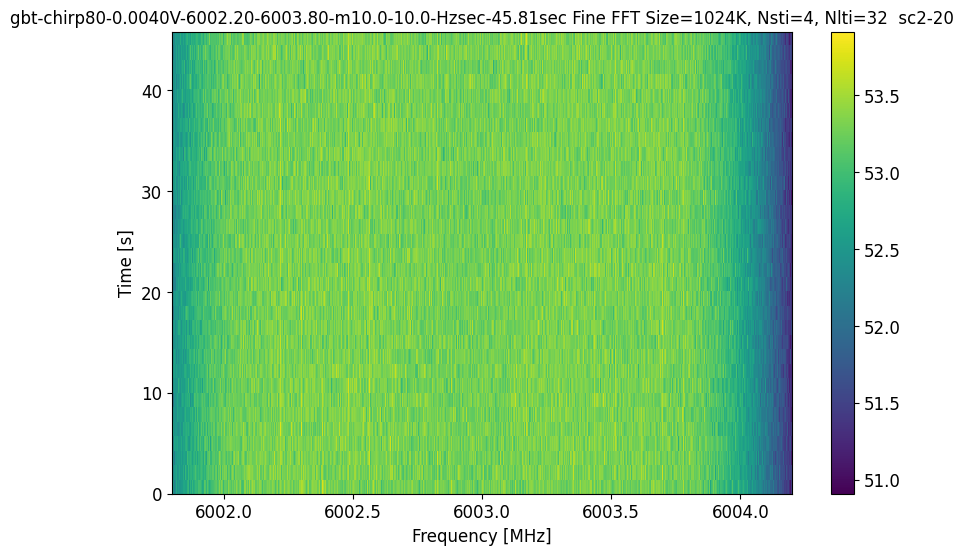

averaging along time axis...


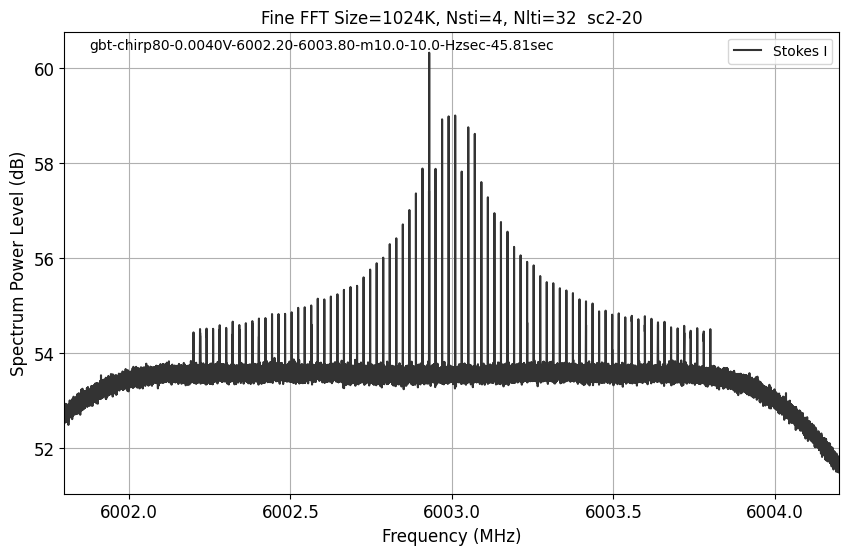

In [13]:
import src.plot_h5_psd_sg1 as plt_h5

if plot_sg_wb & (h5_size_MB<3000.0):

    %matplotlib inline

    plt_h5.plot_h5_sg(base_h5_name,
            fig_f_limits_MHz=fig_f_limits_MHz,
            min_max_db=[],
            fig_title=raw_file_stem  + ' ' + config_str,
            display_fig=display_figs01,
            savfig_name=fig_dir+'01-'+fig_name_base+'-sg-'+test_case+'.png')

if plot_psd_wb  & (h5_size_MB<3000.0):

    %matplotlib inline

    plt_h5.plot_h5_psd_db_bl(base_h5_name,
            fig_f_limits_MHz=fig_f_limits_MHz,
            min_max_db=[],
            fig_title=config_str,
            fig_text_list=[[.15,.85,raw_file_stem]],
            display_fig=display_figs01,
            savfig_name=fig_dir+'02-'+fig_name_base+'-psd-'+test_case+'.png')


#### Run turbo_seti if required

In [14]:
if run_turbo:
    
    from turbo_seti.find_doppler.find_doppler import FindDoppler

    # Get rid of any pre-existing output files from a prior run.
    # for x_file in sorted(os.listdir(output_dir)):
    #     x_type = x_file.split('.')[-1]
    #     if x_type != 'h5':
    #         os.remove(output_dir + x_file)

    # Get ready for search by instantiating the doppler object.
    doppler = FindDoppler(base_h5_name,
                        max_drift = search_max_drift,
                        min_drift = min_abs_drift_Hz_sec,
                        snr = search_z_threshold,       
                        out_dir = output_dir # This is where the turboSETI output files will be stored.
                        )

    t1 = time.time()
    doppler.search()
    t_search0 = time.time() - t1
    t_search = t_search0/n_coarse_channels
    print(f'\TurboSeti Search complete {t_search0:.2f} sec {t_search:.2f} sec/coarse channel')

    print(base_dat_name)
    from turbo_seti.find_event.find_event import read_dat
    det_list = read_dat(base_dat_name)
    
    det_list

#### Run seticore to detect drifting tones and note execution time

In [15]:
if run_seticore:
    seticore_str = search_app_name + ' ' + base_h5_name + \
        ' --max_drift='+ str(search_max_drift) + ' --min_drift=' + str(min_abs_drift_Hz_sec) + \
        ' --snr=' + str(search_z_threshold) + '  --output=' + output_dir + 'testout.dat'

    #    | tee data/output.txt
    if verbose: print(seticore_str)

    t1 = time.time()
    if do_profile:
        os.system('nsys profile ' + seticore_str + ' > seticore_text.out')
    else:
        # os.system(seticore_str)
        os.system(seticore_str+ ' > seticore_text.out')

    t_search0 = time.time() - t1
    t_search = t_search0/p['n_coarse_channels']
    print(f'\nSeticore search: {t_search0:.2f} sec {t_search:.2f} sec/coarse channel')
    
    from turbo_seti.find_event.find_event import read_dat
    det_list = read_dat(output_dir + 'testout.dat')
    det_list


seticore2 /home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec.rawspec.0000.h5 --max_drift=10 --min_drift=0.04 --snr=20  --output=/home/kmh4005/data_files/sg_det_files/testout.dat


dedoppler elapsed time: 1s



Seticore search: 1.45 sec 0.36 sec/coarse channel


In [16]:
# sys.path.append(os.getenv('SETICORE_PY_PATH'))
# import viewer
# import numpy as np
# events = list(viewer.read_events(output_dir + 'testout.hits'))

#### Run bliss to detect drifting tones and note execution time

In [17]:
if run_bliss:
    det_list = []
    
    bliss_str = search_app_name + ' ' + base_h5_name + \
        ' -c 0 --number-coarse ' + str(p['n_coarse_channels']) + \
        ' --nchan-per-coarse ' + str(fine_fft_size) + \
        ' --excise-dc' + ' --device ' + bliss_device_str + ' ' + \
        ' --equalizer-channel ' + '$BL2/' + pfb_file +  \
        ' --min-drift ' + str(search_min_drift) + ' --max-drift '+ str(search_max_drift) + \
        ' --snr ' + str(search_z_threshold) + '  --output ' + output_dir + 'bliss_out.dat'
            
    #    | tee data/output.txt
    if verbose: print(bliss_str)

    t1 = time.time()
    if do_profile:
        os.system('nsys profile ' + bliss_str + ' > bliss_text.out')
    else:
        # os.system(bliss_str)
        os.system(bliss_str+ ' > bliss_text.out')

    t_search0 = time.time() - t1
    t_search = t_search0/p['n_coarse_channels']
    print(f'\nBliss search: {t_search0:.2f} sec {t_search:.2f} sec/coarse channel')
    
    # from turbo_seti.find_event.find_event import read_dat
    # det_list = read_dat(output_dir + 'bliss_out.dat')
    # det_list


In [18]:
if run_bliss:
    from turbo_seti.find_event.find_event import read_dat
    det_list = read_dat(output_dir + 'bliss_out.dat')
det_list

,TopHitNum,DriftRate,SNR,Freq,ChanIndx,FreqStart,FreqEnd,CoarseChanNum,FullNumHitsInRange,FileID,...,RA,DEC,DELTAT,DELTAF,max_drift_rate,obs_length,Hit_ID,status,in_n_ons,RFI_in_range
0,1,-9.757820,122.085808,6002.220252,270371,6002.220252,6002.220252,1,1,testout.dat,...,4.696053,25.691100,1.431656,2.793968,10.000000,45.812984,,,,
1,2,-9.506005,104.852463,6002.240502,277619,6002.240502,6002.240502,1,1,testout.dat,...,4.696053,25.691100,1.431656,2.793968,10.000000,45.812984,,,,
2,3,-9.380098,106.951866,6002.260756,284868,6002.260756,6002.260756,1,1,testout.dat,...,4.696053,25.691100,1.431656,2.793968,10.000000,45.812984,,,,
3,4,-9.128283,110.826027,6002.281012,292118,6002.281012,6002.281012,1,1,testout.dat,...,4.696053,25.691100,1.431656,2.793968,10.000000,45.812984,,,,
4,5,-8.687607,117.987999,6002.301260,299365,6002.301260,6002.301260,1,1,testout.dat,...,4.696053,25.691100,1.431656,2.793968,10.000000,45.812984,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,77,9.506005,111.274529,6003.759502,821290,6003.759502,6003.759502,1,1,testout.dat,...,4.696053,25.691100,1.431656,2.793968,10.000000,45.812984,,,,
77,78,9.820773,134.426132,6003.779752,828538,6003.779752,6003.779752,1,1,testout.dat,...,4.696053,25.691100,1.431656,2.793968,10.000000,45.812984,,,,
78,79,9.946681,110.127190,6003.800003,835786,6003.800003,6003.800003,1,1,testout.dat,...,4.696053,25.691100,1.431656,2.793968,10.000000,45.812984,,,,
79,80,-0.125907,162.630890,6005.859378,524289,6005.859378,6005.859378,2,1,testout.dat,...,4.696053,25.691100,1.431656,2.793968,10.000000,45.812984,,,,


In [19]:
t_total = t_rawspec + t_search
det_f_start_MHz = det_list.values[:,5]
det_drift_rate = det_list.values[:,1]
det_snr_db = db(det_list.values[:,2])
n_det = len(det_snr_db)

if isChirp:
    ii = np.nonzero(np.abs(det_drift_rate)>df_dt_incr/2)
    det_snr_db_wavg = wt_avg(det_snr_db[ii],det_drift_rate[ii],sigma_drift)
else:
    det_snr_db_wavg = np.array(np.nan)

snr_string = 'E(SNR)    ' + np.array2string(det_snr_db_wavg,precision=2) + ' dB'

if verbose: print(snr_string)

det_string_list = []
det_string_ext = ''
for i_det in range(n_det):
    det_string1 = f'{i_det+1} SNR {det_snr_db[i_det]:.2f} dB, {det_f_start_MHz[i_det]:.3f} MHz, {det_drift_rate[i_det]:.3f} Hz/sec'
    det_string_list.append(det_string1)
    det_string_ext = det_string_ext + det_string1+'\n'
# print(det_string_list) 
if verbose: print(det_string_ext)                

E(SNR)    [25.31 25.14 24.44] dB
1 SNR 20.87 dB, 6002.220 MHz, -9.758 Hz/sec
2 SNR 20.21 dB, 6002.241 MHz, -9.506 Hz/sec
3 SNR 20.29 dB, 6002.261 MHz, -9.380 Hz/sec
4 SNR 20.45 dB, 6002.281 MHz, -9.128 Hz/sec
5 SNR 20.72 dB, 6002.301 MHz, -8.688 Hz/sec
6 SNR 20.55 dB, 6002.322 MHz, -8.247 Hz/sec
7 SNR 20.88 dB, 6002.342 MHz, -8.121 Hz/sec
8 SNR 21.06 dB, 6002.362 MHz, -7.932 Hz/sec
9 SNR 20.80 dB, 6002.382 MHz, -7.617 Hz/sec
10 SNR 20.90 dB, 6002.403 MHz, -7.617 Hz/sec
11 SNR 21.36 dB, 6002.423 MHz, -7.240 Hz/sec
12 SNR 21.38 dB, 6002.443 MHz, -6.988 Hz/sec
13 SNR 21.40 dB, 6002.463 MHz, -6.610 Hz/sec
14 SNR 21.84 dB, 6002.484 MHz, -6.484 Hz/sec
15 SNR 21.80 dB, 6002.504 MHz, -6.107 Hz/sec
16 SNR 21.96 dB, 6002.524 MHz, -5.918 Hz/sec
17 SNR 22.25 dB, 6002.544 MHz, -5.666 Hz/sec
18 SNR 22.24 dB, 6002.565 MHz, -5.477 Hz/sec
19 SNR 22.29 dB, 6002.585 MHz, -5.162 Hz/sec
20 SNR 22.66 dB, 6002.605 MHz, -4.910 Hz/sec
21 SNR 22.72 dB, 6002.625 MHz, -4.659 Hz/sec
22 SNR 23.17 dB, 6002.646 MHz, 

#### Zoom plots near center of detected frequencies

In [20]:
if (n_det>0):

        import src.plot_h5_psd_sg1 as plt_h5
        %matplotlib inline

        for i_det in range(min(n_det,max_n_zoom_plots)):
                
                zoom_f_limits_MHz=np.add(det_f_start_MHz[i_det],[-zoom_bw_MHz/2,zoom_bw_MHz/2])
                        
                display_fig = n_det<3
                if plot_sg_psd_zoom:
                        plt_h5.plot_h5_sg_psd(base_h5_name,
                                fig_f_limits_MHz=zoom_f_limits_MHz,
                                min_max_db=[],
                                rel_freq = False,
                                fig_title=config_str + f', Det {i_det+1} of {n_det}',
                                fig_text_list=[[.15,.85,raw_file_stem],[.15,.80,det_string_list[i_det]]],
                                display_fig=display_fig,
                                savfig_name=fig_dir+'03-'+fig_name_base+'-sg-psd-det-'+f'{i_det:02d}-'+test_case+'.png')

                if plot_psd_zoom:
                        plt_h5.plot_h5_psd_db(base_h5_name,
                                fig_f_limits_MHz=zoom_f_limits_MHz,
                                min_max_db=[],
                                rel_freq = False,
                                fig_title=config_str + f', Det {i_det+1} of {n_det}',
                                fig_text_list=[[.15,.85,raw_file_stem],[.15,.80,det_string_list[i_det]]],
                                display_fig=display_figs01,
                                savfig_name=fig_dir+'04-'+fig_name_base+'-psd-det-'+f'{i_det:02d}-'+test_case+'.png')
                
                if plot_sg_zoom:
                       plt_h5.plot_h5_sg(base_h5_name,
                                fig_f_limits_MHz=zoom_f_limits_MHz,
                                min_max_db=[],
                                fig_title=raw_file_stem  + '\n' + config_str + f', Det {i_det+1} of {n_det}',
                                display_fig=display_figs01,
                                savfig_name=fig_dir+'05-'+fig_name_base+'-sg-det-'+f'{i_det:02d}-'+test_case+'.png')

        
                

### Plot detection results - All coarse channels, or just channel with test chirps

[25.31 25.14 24.44]
E(SNR)    [25.31 25.14 24.44] dB


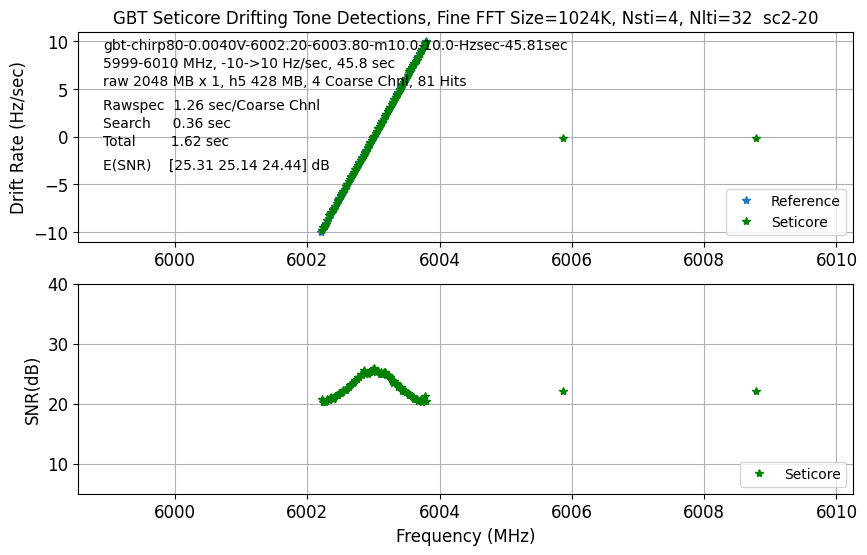

[25.31 25.14 24.44]
E(SNR)    [25.31 25.14 24.44] dB


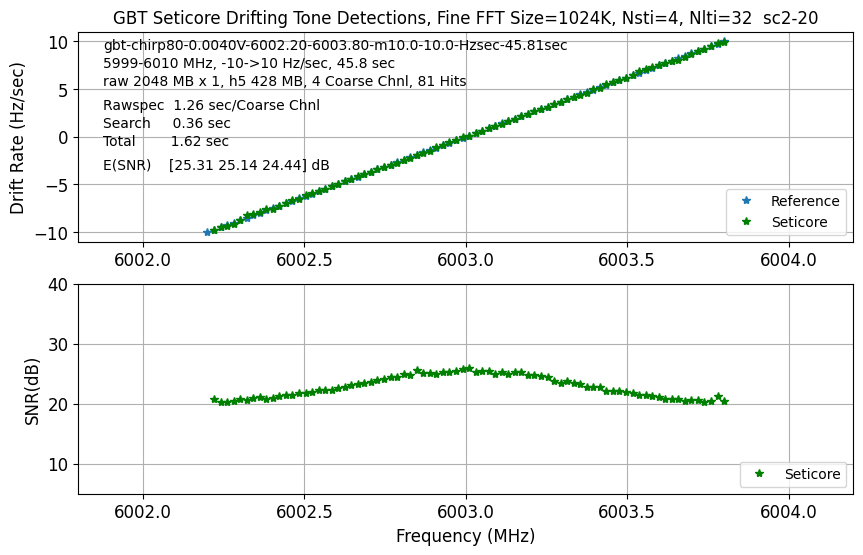

In [21]:
for i_plot in range(2):
    if (i_plot==0):
        # plot over all coarse channels 06-xxx.png
        if not plot_all_dets:
            continue
        else:
            fig_id = '06-'
            f1_MHz = f_min_MHz
            f2_MHz = f_max_MHz
            drift1 = search_min_drift-1
            drift2 = search_max_drift+1
    elif isChirp:
         # plot over one coarse channel with multiple chirps 07-xxx.png
        if not plot_multichirp_dets1:
            continue
        else:
            fig_id = '07-'
            f1_MHz = fig_f_limits_MHz[0]
            f2_MHz = fig_f_limits_MHz[1]
            drift1 = sig_min_drift-1
            drift2 = sig_max_drift+1
   
    %matplotlib inline
    fig = plt.figure(figsize=(10, 6))
    plt.subplot(2,1,1)

    if isChirp: plt.plot(f_start_truth*1e-6 , drift_rate_truth,'*',label='Reference')
    plt.plot(det_f_start_MHz , det_drift_rate,'g*',label=search_app_string)
    plt.title(telescope.upper() + ' '+search_app_string+' Drifting Tone Detections, ' + config_str)

    if isChirp: 
        print(np.array2string(det_snr_db_wavg,precision=2))
        print('E(SNR)    '+ np.array2string(det_snr_db_wavg,precision=2) + ' dB')
    
    plt.xlim(f1_MHz,f2_MHz)
    plt.ylim(drift1,drift2)
    #plt.xlabel('Frequency (MHz)')
    plt.ylabel('Drift Rate (Hz/sec)')
    plt.figtext(.15,.85,raw_file_stem)
    plt.figtext(.15,.82,f'{f_min_MHz:.0f}-{f_max_MHz:.0f} MHz, {search_min_drift:.0f}->{search_max_drift:.0f} Hz/sec, {t_obs:.1f} sec')
    plt.figtext(.15,.79,f'raw {raw_size_MB:3.0f} MB x {p["n_raw_files"]}, h5 {h5_size_MB:3.0f} MB, {n_coarse_channels} Coarse Chnl, {n_det} Hits')
    plt.figtext(.15,.75,f'Rawspec {t_rawspec:5.2f} sec/Coarse Chnl')
    plt.figtext(.15,.72,f'Search    {t_search:5.2f} sec')
    plt.figtext(.15,.69,f'Total       {t_total:5.2f} sec')
    if isChirp: 
        plt.figtext(.15,.65,snr_string)
        plt.legend(loc='lower right')
    plt.grid()                        
    
    plt.subplot(2,1,2)
    
    plt.plot(det_f_start_MHz , det_snr_db,'g*',label=search_app_string)

    plt.xlim(f1_MHz,f2_MHz)
    plt.ylim(5., np.amax((40.,5.*np.ceil(ref_snr_db/5)+5.)))
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('SNR(dB)')
    if isChirp: 
        plt.legend(loc='lower right')
    else:
        if n_det<10:
            plt.figtext(.15,.40-(n_det-1)*.025,det_string_ext)
    
    plt.grid()

    plt.savefig(fig_dir + fig_id + fig_name_base+'-'+search_app_string.lower()+'-det-'+test_case+'.png',bbox_inches='tight')

    if display_figs01:
        plt.show()
    else:
        plt.close(fig)


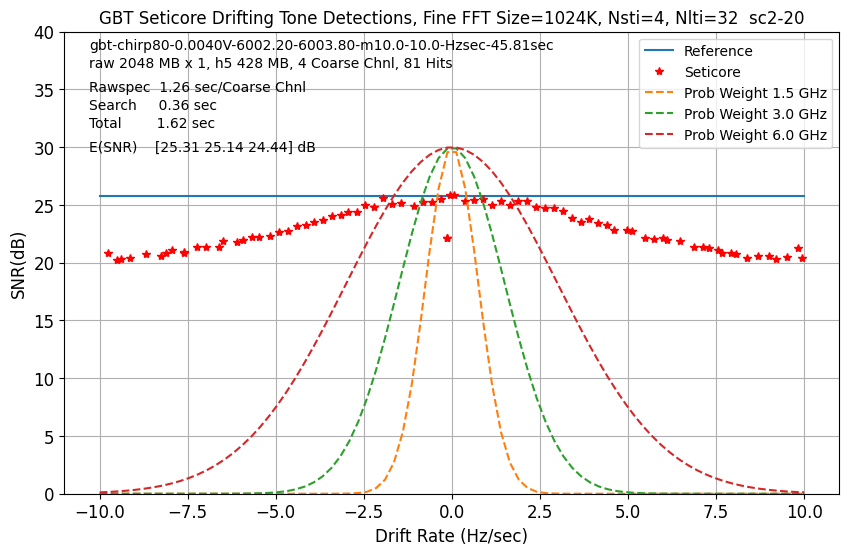

In [22]:

if plot_multichirp_dets2 & isChirp:
        prob_weight = 30*np.exp(-np.square(np.outer(drift_rate_truth,np.reciprocal(sigma_drift)))/2.)
        prob_legend = ['']*len(sigma_drift)
        for i_cfreq,cfreq in enumerate(f_sigma_drift):
                prob_legend[i_cfreq] = f'Prob Weight {cfreq*1e-9:.1f} GHz'

        pltg.plot_generic(x_data=[drift_rate_truth,det_drift_rate,drift_rate_truth],
                y_data=[ref_snr_db*np.ones(np.size(drift_rate_truth)),det_snr_db,prob_weight],
                xy_markers = ['-','r*','--'],
                xy_legend = ['Reference',search_app_string,prob_legend],
                x_limits=[sig_min_drift-1,sig_max_drift+1],
                y_limits=[0., np.amax((40.,5.*np.ceil(ref_snr_db/5)+5.))],
                x_label = 'Drift Rate (Hz/sec)',
                y_label = 'SNR(dB)',
                fig_title= telescope.upper() + ' '+search_app_string+' Drifting Tone Detections, ' + config_str,
                fig_text_list=[[.15,.85,raw_file_stem],
                                [.15,.82,f'raw {raw_size_MB:3.0f} MB x {p["n_raw_files"]}, h5 {h5_size_MB:3.0f} MB, {n_coarse_channels} Coarse Chnl, {n_det} Hits'],
                                [.15,.78,f'Rawspec {t_rawspec:5.2f} sec/Coarse Chnl'],
                                [.15,.75,f'Search    {t_search:5.2f} sec'], 
                                [.15,.72,f'Total       {t_total:5.2f} sec'],
                                [.15,.68,snr_string]],
                legend_loc = 'upper right',
                display_fig=display_figs01,
                savfig_name=fig_dir+'08-' + fig_name_base+'-'+search_app_string.lower()+'-det-'+test_case+'.png')


if False & plot_multichirp_dets2 & isChirp:
        
        pltg.plot_generic(x_data=[drift_rate_truth,det_drift_rate],
                y_data=[ref_snr_db*np.ones(np.size(drift_rate_truth)),det_snr_db],
                xy_markers = ['-','r*'],
                xy_legend = ['Reference','Seticore'],
                x_limits=[sig_min_drift-1,sig_max_drift+1],
                y_limits=[5., np.amax((45.,5.*np.ceil(ref_snr_db/5)+5.))],
                x_label = 'Drift Rate (Hz/sec)',
                y_label = 'SNR(dB)',
                fig_title= telescope.upper() + ' '+search_app_string+' Drifting Tone Detections, ' + config_str,
                fig_text_list=[[.15,.85,raw_file_stem],
                                [.15,.82,f'raw {raw_size_MB:3.0f} MB x {p["n_raw_files"]}, h5 {h5_size_MB:3.0f} MB, {n_coarse_channels} Coarse Chnl, {n_det} Hits'],
                                [.15,.78,f'Rawspec {t_rawspec:5.2f} sec/Coarse Chnl'],
                                [.15,.75,f'Search    {t_search:5.2f} sec'], 
                                [.15,.72,f'Total       {t_total:5.2f} sec'],
                                [.15,.68,snr_string]],
                legend_loc = 'lower right',
                display_fig=display_figs01,
                savfig_name=fig_dir+'09-' + fig_name_base+'-'+search_app_string.lower()+'-det-'+test_case+'.png')



In [23]:
t_e2e = time.time() - t_e2e_start
print(f'SETI end-to-end completed, {t_e2e:.2f} sec\n')

SETI end-to-end completed, 10.14 sec



#### Delete spectrogram and raw files as needed

In [24]:
if delete_h5_sg_file:
    os.system('rm '+f'{new_h5_name}')
    print(f'h5 sg file deleted\n{new_h5_name}\n')
    
if delete_raw_file:
    os.system('rm '+f'{raw_file_delete_spec}')
    print(f'raw file(s) deleted\n{raw_file_delete_spec}\n')


In [25]:
# os.system("echo -ne '\007'")
# os.system("echo -ne '\a'")
# os.system("tput bel")
# print("\007")


In [26]:
# Beep in WSL
os.system("powershell.exe '[console]::beep(261.6,700)'")

0